In [1]:
import numpy as np
import math
from itertools import combinations,product
from collections import defaultdict, OrderedDict, Counter
import sys, os
import matplotlib
from matplotlib import pyplot as plt
from numba import jit
from scipy import stats, linalg
import pickle 
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from tigramite.pcmci import PCMCI
from tigramite.pcmci_base import PCMCIbase
from tigramite import plotting as tp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests.oracle_conditional_independence import OracleCI
from tigramite.independence_tests.parcorr import ParCorr
# from tigramite.independence_tests.parcorr_mult import ParCorrMult
from vector_CD.cond_ind_tests.parcorr_mult_regularized import ParCorrMult
import tigramite.data_processing as pp

import vector_CD.data_generation.gen_data_vecCI_ext as gen
import vector_CD.data_generation.mult_data_gen_methods as mech

def lin_f(x): return x

## Main Functions

In [2]:
def lin_f(x): return x
def nonlin_f(x): return (x + 5. * x**2 * np.exp(-x**2 / 20.))

In [3]:
def comp_ind_score(data,p_matrix,sepsets, N_array,pc_alpha, ci_test='parcorr_gcm_gmb'):
    
    #print(data.shape)
    ind_score = 0
    den=0
    
    if ci_test == 'parcorr_maxcorr':
        ci_test = ParCorrMult(significance='analytic')
    elif ci_test == 'parcorr_gcm_gmb':
        ci_test = ParCorrMult(
                    correlation_type = 'gcm_gmb',
                    regularization_model = LinearRegression(),
                    significance = 'shuffle_test',
                    sig_blocklength=1,
                    sig_samples=200)
        
    else:
        raise ValueError("ci_test not available for independence score")

    for (i1,j1) in product(range(len(N_array)),range(len(N_array))): 
        if i1 > j1:
            if p_matrix[i1,j1] >= pc_alpha: #Edge deletion condition
                
                den+=1              
                N = len(N_array)

                if N<2:
                    vector_vars = None
                else:
                    vector_vars = {}
                    l=0
                    for i in range(N):
                        j = N_array[i]
                        for k in range(j):
                            if k==0:
                                vector_vars[i] = [(k+l,0)] 
                            else:
                                vector_vars[i].append((k+l,0)) 
                        l+=j


                dataframe_vec  =  pp.DataFrame(data, vector_vars = vector_vars, analysis_mode = 'single')
                ci_test.set_dataframe(dataframe_vec)  
                
                pval_agg = ci_test.run_test(
                    X=[(i1,0)], 
                    Y=[(j1,0)],
                    Z = sepsets[((i1,0),j1)]
                    )[1]

                if pval_agg >= pc_alpha: 
                    ind_score+=1
                    
    return ind_score,den


def validity_score_list(N_array, min_coeff, max_coeff, step_size, T, method, pc_alpha, N_fine=None, neg_coeff=True, ci_test='parcorr_gcm_gmb'):
    
    coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
    coupling_range = len(coupling_coeffs)
    scores = np.zeros(coupling_range+1)
    dens = np.zeros(coupling_range+1)
    shd_to_true_graph = np.zeros(coupling_range+1)

    for j in range(coupling_range +1):

        links_full, links_vec = gen.generate_random_contemp_vec_model(
        N_array, 
        coupling_coeffs, 
        coupling_funcs, 
        auto_coeffs_array, 
        tau_max, 
        contemp_frac_array,
        contemp_frac,
        L_internal_density = None,
        L_external_density = None,
        random_state=None)

        N = len(links_full.keys())

        # Vector data
        data, nonstat = gen.generate_nonlinear_contemp_timeseries(links_full,
            T, noises=[np.random.randn for i in range(N)])
        true_graph = toys.links_to_graph(links_vec)

        # Aggregated data
        data_agg = aggregate_data(data, N_array)

        # PC-alg on aggregated data
        sepsets,p_matrix,graph,dag = pc_alg(data_agg,pc_alpha,ci_test=ci_test)

        if method == 'ind':
            # Compute independence score
            scores[j],dens[j] = comp_ind_score(data,p_matrix,sepsets,N_array,pc_alpha, ci_test)
            
        elif method == 'comm':
            if N_fine == None:
                raise ValueError("Specify fine partition for commutativity method")
            else:
                fine_vec_var = vectorize_to_fine(N_fine,N_array)
                data_agg_fine = aggregate_data(data, N_fine)
                sepsets_fine, p_matrix_fine, graph_fine, dag_fine = pc_alg(data_agg_fine, pc_alpha,vector_vars=fine_vec_var, ci_test=ci_test)
                #graph_coarse, graph_fine = dags_coarse_fine(data,fine_vec_var,N_array,N_fine,pc_alpha)
                scores[j] = shd(dag, dag_fine) 
                
        shd_to_true_graph[j] = shd(true_graph,dag)
        
        #fpr_true_agg[j] = fpr_graph(true_graph,graph)
        
        if neg_coeff:  
            if j < coupling_range:
                coupling_coeffs += [-c for c in [coupling_coeffs[j]]]
                #print(coupling_coeffs)
                #print('average coeff', (np.array(coupling_coeffs)).mean())
        else:
            break 
            
    if method == 'ind':
        scores = scores/dens
        #TODO : Remove NaNs
            
            
    return scores,shd_to_true_graph


##### Trying to write a better/modular version of the previous function or directly incorporate in calculate()
##### Desiderata:
##### ----------
# 1. Incorporate parcorr_gcmgmb as an arguement
# 2. choose data_gen to be coarse_dag or MRF
# 3. Arguement neg AND pca_weight, that specifies the coeff_range or pca_weighting, resp., used in the data_mrf_ts
# 4. Output true_graph, pred_graph (aftetr aggregation), SHD (need pc_alg output for that)

## Helper Functions

In [4]:
def aggregate_data(data, partition):
    
    for m,n in enumerate(partition):        
        agg_m = np.mean([data[:,i] for i in range(sum(partition[:m]), sum(partition[:m+1]))],axis=0)        
        if m==0:
            data_agg = agg_m            
        else:
            data_agg = np.vstack((data_agg,agg_m))        
    return np.transpose(data_agg)
        
def agg_data_by_method(agg_method, data, d_micro, d_macro):
    
    if agg_method == 'avg':
        partition = [d_micro]*d_macro
        for m,n in enumerate(partition):        
            agg_m = np.mean([data[:,i] for i in range(sum(partition[:m]), sum(partition[:m+1]))],axis=0)        
            if m==0:
                data_agg = agg_m            
            else:
                data_agg = np.vstack((data_agg,agg_m)) 
            vector_vars = None
        return np.transpose(data_agg), vector_vars
    
    elif 'pca' in agg_method:
        p_comps  = int(method.replace('pca_',''))
        T, _ = data.shape
        pca_data = np.zeros((T, int(p_comps*d_macro)))
        count=0
        for i in range(d_macro):
            X = data[:,count:count+d_micro]
            pca = PCA(n_components=p_comps).fit(X)
            pca_data[:,p_comps*i:p_comps*(i+1)] = X.dot(pca.components_.T)#.reshape((T,p_comps))
            count += d_micro
            if p_comps == 1:
                vector_vars = None
            else:
                vector_vars = vector_vars_from_Narray(d_macro,p_comps)
        return pca_data, vector_vars
    
def vector_vars_from_Narray(d_macro,d_micro):
    N_array = [d_micro]*d_macro
    
    N = len(N_array)
    if N<2:
        vector_vars = None
    else:
        vector_vars = {}
        l=0
        for i in range(N):
            j = N_array[i]
            for k in range(j):
                if k==0:
                    vector_vars[i] = [(k+l,0)] #only defining contemporaneous vector_vars here !!!
                else:
                    vector_vars[i].append((k+l,0)) #only defining contemporaneous vector_vars here !!!
            l+=j
    return vector_vars


def pc_alg(data_agg, pc_alpha,vector_vars = None, ci_test = 'parcorr_gcm_gmb', verbosity = 0,cr = True):
    
    # PC-alg on aggregated data
    
    if vector_vars ==None:
        dataframe = pp.DataFrame(data_agg, analysis_mode = 'single')
        parcorr = ParCorr(significance='analytic')
        ci_test = parcorr
        
    else: 
        dataframe  =  pp.DataFrame(data_agg, vector_vars = vector_vars, analysis_mode = 'single')
        
        if 'parcorr_maxcorr' in ci_test:
            ci_test = ParCorrMult(significance='analytic')
        elif ci_test == 'parcorr_gcm_gmb':
            ci_test = ParCorrMult(
                        correlation_type = 'gcm_gmb',
                        regularization_model = LinearRegression(),
                        significance = 'shuffle_test',
                        sig_blocklength=1,
                        sig_samples=200)
        else: 
            raise ValueError("Multivariate CI test not included in suite")
            

    pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=ci_test,
        verbosity=verbosity)

    results = pcmci.run_pcalg(tau_max=0, pc_alpha=pc_alpha, conflict_resolution=cr)
    p_matrix = results['p_matrix']
    sepsets = results['sepsets']
    graph = results['graph']
    val_matrix = results['val_matrix']
    variable_order = np.argsort(
                                np.abs(val_matrix).sum(axis=(0,2)))[::-1]
    
    pcmci_base = PCMCIbase(
        dataframe=dataframe, 
        cond_ind_test=ci_test,
        verbosity=verbosity)
    dag = pcmci_base._get_dag_from_cpdag(graph, variable_order)
    
    return sepsets,p_matrix,graph,dag

def graph_to_dict(graph):
    """Helper function to convert graph to dictionary of links.

    Parameters
    ---------
    graph : array of shape (N, N, tau_max+1)
        Matrix format of graph in string format.

    Returns
    -------
    links : dict
        Dictionary of form {0:{(0, -1): o-o, ...}, 1:{...}, ...}.
    """
    N = graph.shape[0]

    links = dict([(j, []) for j in range(N)])
    #links_old = dict([(j, {}) for j in range(N)])

    for (i, j, tau) in zip(*np.where(graph!='')):
        if i<j:
            if graph[i,j,tau] == '-->':
                links[j].append(((i,-tau),)) # last comma needed to create a tuple of tuple
            elif graph[i,j,tau] == '<--':
                links[i].append(((j,-tau),))
            # else:
            #     raise ValueError('not a dag')
            
        #links_old[j][(i, -tau)] = graph[i,j,tau]

    return links

def links_to_binary_graph(links, symmetrize=False):
    
    #set symmetrize to false if you need adjacencies to be a dict of the {child:(parent,lag)} form
    # if symmetrize is default, i.e. True, the adjacency matrix is not directional
    
    N = len(links)
    initial_graph = np.zeros((N, N, tau_max + 1), dtype='float')
    for j in range(N):
        for link in links[j]:
            i, tau = link[0]
            initial_graph[j, i, abs(tau)] = 1
            if symmetrize==True:
                initial_graph[i, j, abs(tau)] = 1
            
    return initial_graph

def shd(graph_true, graph_pred, double_for_anticausal = True):
    
    # graphs inputs for SHD must be DAGs
    
    links_true= graph_to_dict(graph_true)
    links_pred= graph_to_dict(graph_pred)
    
    #print(links_true, links_pred)

    adj_true = links_to_binary_graph(links_true)[:,:,0]
    adj_pred = links_to_binary_graph(links_pred)[:,:,0]
    
    #print(adj_true, adj_pred)
    
    diff = np.abs(adj_true - adj_pred)
    
    #print(diff)
    if double_for_anticausal:
        return np.sum(diff)
    else:
        diff = diff + diff.transpose()
        diff[diff > 1] = 1  # Ignoring the double edges.
        return np.sum(diff)/2
    
def vectorize_to_fine(N_fine, N_array):
    
    tot_fine  = len(N_fine)
    tot_coarse = len(N_array)
    
    N_new = [tot_fine-tot_coarse+1]+[1]*(tot_coarse-1)
    #N_new = [tot_fine-2,1,1]
    #N_new  = N_proxy

    vector_vars = {}
    N = len(N_new)
    l=0
    for i in range(N):
        j = N_new[i]
        for k in range(j):
            if k==0:
                vector_vars[i] = [(k+l,0)] 
            else:
                vector_vars[i].append((k+l,0)) 
        l+=j

    return vector_vars

def coeff_avg_list(min_coeff,max_coeff,step_size, neg=True):
    coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
    coupling_range = len(coupling_coeffs)
    coeff_avg = np.zeros((coupling_range+1,))
    
    
    for j in range(coupling_range+1):
        coeff_avg[j] = (np.array(coupling_coeffs)).mean()
    
        if neg:  
                if j < coupling_range:
                    coupling_coeffs += [-c for c in [coupling_coeffs[j]]]
        else:
            coeff_avg = np.array([coeff_avg[0]])
            break
                    
        j+=1
    
    return coeff_avg

## Retrieve Metrics

In [5]:
folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/metrics/'

def get_metrics_from_config(para_setup):
    file_name = folder_name + para_setup + '_metrics'
    try:
        results = pickle.load(open(file_name.replace("'", "").replace('"', '') + '.dat', 'rb'), encoding='latin1')
    except:
        print("failed  ", file_name.replace("'", "").replace('"', '') + '.dat')
        return None
    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    results = get_metrics_from_file(para_setup_str)
    return results    

def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    name_string = name_string[:-1]
    #print(name_string% (para_setup))

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

        

## Plots

### AVERAGE: Single Sample Size, Compare increasing d_micro

In [273]:
## Copy from submit file

anyconfigurations = []
                                                            
for agg_method in ['avg']:#, 'pca_1']:
    for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [5]:
            for d_micro in [5,10,20,50]:   
                for T in [1000]:
                    for coeff in [0.5]:
                        for auto in [0.3]:
                            for contemp_frac in [1.]:
                                for pc_alpha in [0.01]:
                                    for tau_max in [0]:
                                        for ci_test in ['parcorr_gcm_gmb']: #'parcorr_maxcorr'
                                            for internal_ER in [0.3]:
                                                for external_ER in [0.5]: 
                                                    for neg in [0., 0.2, 0.4, 0.6, 0.8, 1.]:
                                                        for pca_weight in ['None']: #[0.,0.1,0.2,0.3,0.4]:
                                                            para_setup = (agg_method,data_gen,d_macro,d_micro,T,coeff,auto,contemp_frac,
                                                                pc_alpha,tau_max,ci_test,internal_ER,external_ER,neg,pca_weight)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]
                                                            
config_list  = anyconfigurations                                                            

In [278]:
get_metrics_from_config(config_list[0])

{'adj_anylink_precision': (0.8812877263581489, 0.012440331499048536),
 'adj_anylink_recall': (0.876, 0.01329044393539961),
 'all_precision': (0.358148893360161, 0.029485126037106946),
 'all_recall': (0.356, 0.029269504608038722),
 'edgemarks_anylink_precision': (0.358148893360161, 0.02815329466095861),
 'edgemarks_anylink_recall': (0.356, 0.029161618610769872),
 'unoriented_anylink': (0.0, 0.0),
 'conflicts_anylink': (0.014084507042253521, 0.0065119369585165164),
 'ind_score': (0.8102347619047618, 0.017638362810374036),
 'dep_score': (1.0, 0.0),
 'shd': (3.82355, 0.21125552655492827),
 'computation_time': (0.2342531418800354, array([0.2012296 , 0.27069407]))}

In [301]:
neg_list  = [0., 0.2, 0.4, 0.6, 0.8, 1.]
def ind_score_group_size_plots(config_list, which = ['adj_anylink_recall'] , x=neg_list, save= 'no'):
    
    ## FOR VERTICAL PANEL
    # fig, (axs) = plt.subplots(4,1, figsize=(6,  16))#, layout="constrained")
    
    ## FOR HORIZONTAL PANEL
    # fig, (axs) = plt.subplots(1,4, figsize=(32,  4))#, layout="constrained")
    
    ## FOR HORIZONTAL PANEL
    fig, (axs) = plt.subplots(2,2, figsize=(14,  8))#, layout="constrained")
    axs = axs.ravel()
    count = 0
    for ind,which in enumerate(which):

        for j in range(4):
            y = []
            y_err = []
            for i in range(len(x)):
                results = get_metrics_from_config(config_list[i+count])
                # y.append(results['adj_anylink_precision'][0])
                # y_err.append(results['adj_anylink_precision'][1]) 
                
                y.append(results['ind_score'][0])
                y_err.append(results['ind_score'][1])
                # y.append(results['dep_score'][0])
                # y_err.append(results['dep_score'][1])

            # y = np.ones(len(x))-y ## UNCOMMENT if which == 'shd'
            color1 = 'tab:red'
            paralist = config_list[count].split('-')
            d_macro = int(paralist[2])
            d_micro = int(paralist[3])
            T = int(paralist[4])
            offset = int(4*ind)
            axs[j+offset].plot(x,y, label = d_micro,color=color1)
            axs[j+offset].errorbar(x,y,yerr = y_err,color=color1,marker='o')
            # axs[j].set_xlabel('decreasing coeff_average')
            # axs[j+offset].set_ylabel('ind_score',color=color1)
            axs[j+offset].tick_params(axis='y', labelcolor=color1)
            axs[j+offset].grid(True)
            axs[j+offset].set_ylim(0.0, 1.0)
            # axs[j+offset].legend()
            toptext = 'T='+str(T)+'$, d_{micro}=$'+str(d_micro)  #+', d_micro='+str(d_micro)
            # middletext = '$d_{micro}=$'+str(d_micro)
            bottomtext = '$d_{macro}=$'+str(d_macro)
            
            ## FOR VERTICAL PANEL
            # axs[j+offset].annotate(toptext+"\n"+bottomtext, xy=(320, 40), xycoords='axes points',
            #     size=8, ha='right', va='top',
            #     bbox=dict(boxstyle='round', fc='w'))
            ## FOR HORIZONTAL PANEL
            axs[j+offset].annotate(toptext+"\n"+bottomtext, xy=(340, 50), xycoords='axes points',
                size=14, ha='right', va='top',
                bbox=dict(boxstyle='round', fc='w'))
            #For SHD
            # axs[j+offset].annotate(toptext+"\n"+bottomtext, xy=(340, 190), xycoords='axes points',
            #     size=14, ha='right', va='top',
            #     bbox=dict(boxstyle='round', fc='w'))
           


            ax_twin = axs[j+offset].twinx()
            color = 'tab:green'
            y_which = []
            y_which_err = []
            for i in range(len(x)):
                results = get_metrics_from_config(config_list[i+count])    
                y_which.append(results[which][0])
                y_which_err.append(results[which][1])

            # ax_twin.set_ylabel(which, color=color)  
            ax_twin.plot(x, y_which, color=color)
            ax_twin.errorbar(x, y_which, yerr=y_which_err,color=color,marker='o')
            ax_twin.tick_params(axis='y', labelcolor=color)
            ax_twin.set_ylim(0.0, 1.0)

            count += len(x)
            
        
        ## FOR VERTICAL PANEL
        # plt.figtext(0.5, 0.08, r"decreasing coeff_avg", fontsize=12,
        #                 horizontalalignment='center', va='bottom')
        ## FOR HORIZONTAL PANEL
        # plt.figtext(0.5, 0., r"decreasing coeff_avg", fontsize=18,
        #                 horizontalalignment='center', va='bottom')

    if save == 'yes':
        save_type = 'pdf'
        save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
        para_setup_name = (agg_method,which,T,internal_ER, external_ER)
        save_suffix = '%s-'*len(para_setup_name) % para_setup_name
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

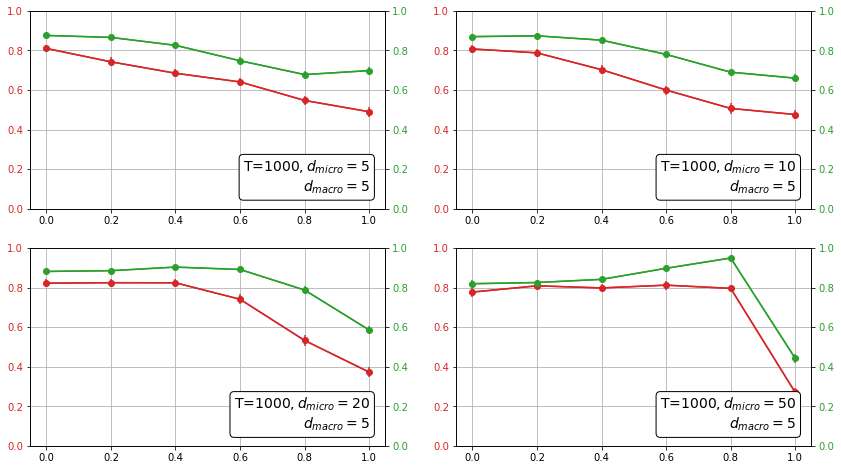

In [302]:
neg_list  = [0., 0.2, 0.4, 0.6, 0.8, 1.]
which = ['adj_anylink_recall']
ind_score_group_size_plots(config_list, which = which, x = neg_list,save = 'no')

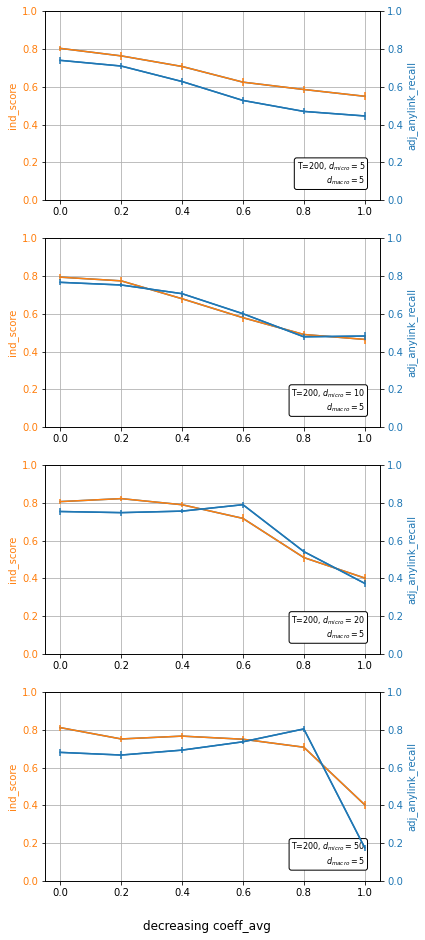

In [425]:
neg_list  = [0., 0.2, 0.4, 0.6, 0.8, 1.]
which = ['adj_anylink_recall']
ind_score_group_size_plots(config_list, which = which, x = neg_list)

### AVERAGE: Single Sample Size, Compare increasing d_micro

In [263]:
anyconfigurations = []
                                                            
for agg_method in ['avg']:#, 'pca_1']:
    for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [5]:
            for d_micro in [3]:   
                for T in [200]:
                    for coeff in [0.5]:
                        for auto in [0.3]:
                            for contemp_frac in [0.]:
                                for pc_alpha in [0.01]:
                                    for tau_max in [1]:
                                        for ci_test in ['parcorr_gcm_gmb']: #'parcorr_maxcorr'
                                            for internal_ER in [0.3]:
                                                for external_ER in [0.5]: 
                                                    for neg in [0., 0.2, 0.4, 0.6, 0.8, 1.]:
                                                        for pca_weight in ['None']: #[0.,0.1,0.2,0.3,0.4]:
                                                            para_setup = (agg_method,data_gen,d_macro,d_micro,T,coeff,auto,contemp_frac,
                                                                pc_alpha,tau_max,ci_test,internal_ER,external_ER,neg,pca_weight)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]
                                                            
config_list  = anyconfigurations  
config_list

['avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-0.0-None',
 'avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-0.2-None',
 'avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-0.4-None',
 'avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-0.6-None',
 'avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-0.8-None',
 'avg-mrf_ts-5-3-200-0.5-0.3-0.0-0.01-1-parcorr_gcm_gmb-0.3-0.5-1.0-None']

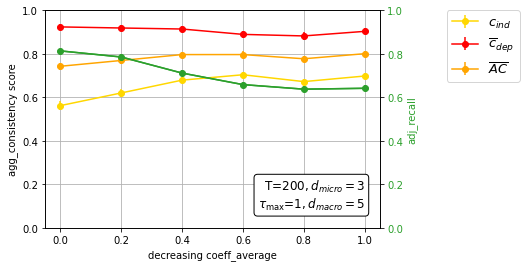

In [267]:
save= 'yes'
x  = [0., 0.2, 0.4, 0.6, 0.8, 1.]
which = 'adj_anylink_recall'#'adj_anylink_precision' # 'adj_anylink_recall'


y_ind = []
y_ind_err = []

y_dep = []
y_dep_err = []
fig, (axs) = plt.subplots(1,1, figsize=(6,  4))#, layout="constrained")
for i in range(len(x)):
    results = get_metrics_from_config(config_list[i])
    
    y_ind.append(results['ind_score'][0])
    y_ind_err.append(results['ind_score'][1])
    
    y_dep.append(results['dep_score'][0])
    y_dep_err.append(results['dep_score'][1])
    
color1 = 'tab:orange'
# axs.plot(x,y)

y_ac = (np.array(y_ind)+np.array(y_dep))/2
y_ac_err = (np.array(y_ind_err) + np.array(y_dep_err))/2

axs.errorbar(x,y_ind,yerr = y_ind_err,label = '$c_{ind}$',marker='o',color = 'gold')
axs.errorbar(x,y_dep,yerr = y_dep_err,label = '$\\overline{c}_{dep}$', marker='o',color = 'red')
axs.errorbar(x,y_ac,yerr = y_ac_err, label = '$\\overline{AC}$', marker='o',color = 'orange')

axs.set_xlabel('decreasing coeff_average')
axs.set_ylabel('agg_consistency score')#,color=color1)
axs.tick_params(axis='y')#, labelcolor=color1)
axs.set_ylim(0.0, 1.0)
axs.grid(True)
axs.legend(bbox_to_anchor=(1.2, 1.), loc='upper left', borderaxespad=0., prop={'size': 13})

ax_twin = axs.twinx()
color = 'tab:green'
y_which = []
y_which_err = []
for i in range(len(x)):
    results = get_metrics_from_config(config_list[i])    
    y_which.append(results[which][0])
    y_which_err.append(results[which][1])

# ax_twin.set_ylabel(which, color=color)  
ax_twin.plot(x, y_which, color=color)
ax_twin.errorbar(x, y_which, yerr=y_which_err, label = which, color=color,marker='o')
ax_twin.tick_params(axis='y', labelcolor=color)
ax_twin.set_ylim(0.0, 1.0)
ax_twin.set_ylabel('adj_recall', color=color)
# ax_twin.legend(bbox_to_anchor=(1.2, 0.7), loc='upper left', borderaxespad=0., prop={'size': 13})


paralist = config_list[0].split('-')
d_macro = int(paralist[2])
d_micro = int(paralist[3])
T = int(paralist[4])
tau = int(paralist[9])
toptext = 'T='+str(T)+'$, d_{micro}=$'+str(d_micro)  
bottomtext = '$\\tau_{\max}$='+str(tau)+'$, d_{macro}=$'+str(d_macro)
axs.annotate(toptext+"\n"+bottomtext, xy=(320, 50), xycoords='axes points',
    size=12, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))
    
    
if save == 'yes':
    save_type = 'pdf'
    save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    para_setup_name = (agg_method,which,d_macro,d_micro,T,internal_ER, external_ER)
    save_suffix = '%s-'*len(para_setup_name) % para_setup_name
    save_suffix = 'all_scores-'+save_suffix
    fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

### PCA: Single Sample Size, Compare increasing d_micro

In [418]:
## Copy from submit file

anyconfigurations = []
                                                            
for agg_method in ['pca_1']:# ['avg','pca_1']:
    for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [5]:
            for d_micro in [5,10,20,50]:   
                for T in [1000]:
                    for coeff in [0.5]:
                        for auto in [0.3]:
                            for contemp_frac in [1.]:
                                for pc_alpha in [0.01]:
                                    for tau_max in [0]:
                                        for ci_test in ['parcorr_gcm_gmb']: #'parcorr_maxcorr'
                                            for internal_ER in [0.3]:
                                                for external_ER in [0.5]: 
                                                    for neg in [1.0]:#[0., 0.2, 0.4, 0.6, 0.8, 1.]:
                                                        for pca_weight in [0.,0.1,0.2,0.3,0.4]: #[0.,0.1,0.2,0.3,0.4]: #['None']
                                                            para_setup = (agg_method,data_gen,d_macro,d_micro,T,coeff,auto,contemp_frac,
                                                                pc_alpha,tau_max,ci_test,internal_ER,external_ER,neg,pca_weight)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]
                                                            
config_list  = anyconfigurations  

# results = get_metrics_from_config(config_list[0])  
# results

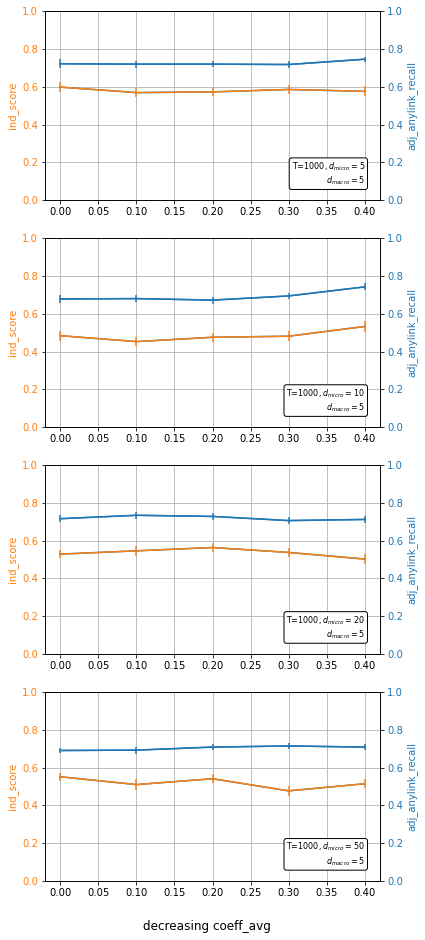

In [419]:
pca_wt_list = [0.,0.1,0.2,0.3,0.4]
ind_score_group_size_plots(config_list, which = ['adj_anylink_recall'] , x = pca_wt_list, save= 'no')

### PCA: comparing increasing p_comps

In [434]:
anyconfigurations = []
for agg_method in ['pca_1', 'pca_2','pca_3', 'pca_4']:# ['avg','pca_1']:
    for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [5]:
            for d_micro in [50]:   
                for T in [1000]:
                    for coeff in [0.5]:
                        for auto in [0.3]:
                            for contemp_frac in [1.]:
                                for pc_alpha in [0.01]:
                                    for tau_max in [0]:
                                        for ci_test in ['parcorr_gcm_gmb']: #'parcorr_maxcorr'
                                            for internal_ER in [0.3]:
                                                for external_ER in [0.5]: 
                                                    for neg in [1.0]:#[0., 0.2, 0.4, 0.6, 0.8, 1.]:
                                                        for pca_weight in ['None']:#,0.1,0.2,0.3,0.4]: #[0.,0.1,0.2,0.3,0.4]: #['None']
                                                            para_setup = (agg_method,data_gen,d_macro,d_micro,T,coeff,auto,contemp_frac,
                                                                pc_alpha,tau_max,ci_test,internal_ER,external_ER,neg,pca_weight)
                                                            name = '%s-'*len(para_setup) % para_setup
                                                            name = name[:-1]
                                                            anyconfigurations += [name]
config_list = anyconfigurations

In [435]:
config_list

['pca_1-mrf_ts-5-50-1000-0.5-0.3-1.0-0.01-0-parcorr_gcm_gmb-0.3-0.5-1.0-None',
 'pca_2-mrf_ts-5-50-1000-0.5-0.3-1.0-0.01-0-parcorr_gcm_gmb-0.3-0.5-1.0-None',
 'pca_3-mrf_ts-5-50-1000-0.5-0.3-1.0-0.01-0-parcorr_gcm_gmb-0.3-0.5-1.0-None',
 'pca_4-mrf_ts-5-50-1000-0.5-0.3-1.0-0.01-0-parcorr_gcm_gmb-0.3-0.5-1.0-None']

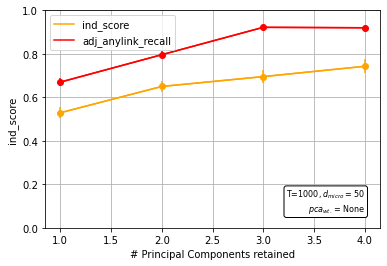

In [436]:
which  = 'adj_anylink_recall'
save = 'yes'
fig, (axs) = plt.subplots(1,1, figsize=(6,  4))#, layout="constrained")
x = [1,2,3,4]
y = []
y_err = []
y2 = []
y2_err = []
for i in range(len(x)):
    results = get_metrics_from_config(config_list[i])
    # print(results, '---\n')
    y.append(results['ind_score'][0])
    y_err.append(results['ind_score'][1])
    y2.append(results[which][0])
    y2_err.append(results[which][1])
    
# color1 = 'tab:orange'
paralist = config_list[0].split('-')
d_macro = int(paralist[2])
d_micro = int(paralist[3])
T = int(paralist[4])
# pca_weight =  float(paralist[14])


axs.plot(x,y, label = 'ind_score',color= 'orange')
axs.errorbar(x,y,yerr = y_err,color= 'orange', marker='o')
axs.plot(x,y2, label = which,color= 'red')
axs.errorbar(x,y2,yerr = y2_err,color='red', marker='o')
axs.legend()
axs.set_xlabel('# Principal Components retained')
axs.set_ylabel('ind_score')#,color=color1)
axs.tick_params(axis='y')#, labelcolor=color1)
axs.grid(True)
axs.set_ylim(0.0, 1.0)


toptext = 'T='+str(T)+'$, d_{micro}=$'+str(d_micro)  #+', d_micro='+str(d_micro)
# # middletext = '$d_{micro}=$'+str(d_micro)
bottomtext = '$pca_{wt.}=$'+str(pca_weight)
axs.annotate(toptext+"\n"+bottomtext, xy=(320, 40), xycoords='axes points',
    size=8, ha='right', va='top',
    bbox=dict(boxstyle='round', fc='w'))

if save == 'yes':
    save_type = 'pdf'
    save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    para_setup_name = (d_micro,pca_weight,which,T,internal_ER, external_ER)
    save_suffix = '%s-'*len(para_setup_name) % para_setup_name
    save_suffix = 'PCA_comps-'+save_suffix
    fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

## Trials for prettier plots 

In [420]:
## PCA_WEIGHT, SINGLE SAMPLE SIZE, INCREASING D_MICR0
##################################################
#save = 'no'
# which_plots  = ['adj_anylink_recall']#['shd']#['adj_anylink_recall'] # ['shd']

# fig, (axs) = plt.subplots(4,1, figsize=(6,  16))#, layout="constrained")
# x = [0., 0.1, 0.2, 0.3, 0.4]
# axs = axs.ravel()
# count = 0
# for ind,which in enumerate(which_plots):     
#     for j in range(4):
#         y = []
#         y_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[i+count])
#             y.append(results['ind_score'][0])
#             y_err.append(results['ind_score'][1])

#         # y = np.ones(len(x))-y ## activate if which == 'shd'
#         color1 = 'tab:orange'
#         paralist = config_list[count].split('-')
#         d_macro = int(paralist[2])
#         d_micro = int(paralist[3])
#         T = int(paralist[4])
#         offset = int(4*ind)
#         axs[j+offset].plot(x,y, label = d_micro)
#         axs[j+offset].errorbar(x,y,yerr = y_err)
#         # axs[j].set_xlabel('decreasing coeff_average')
#         axs[j+offset].set_ylabel('ind_score',color=color1)
#         axs[j+offset].tick_params(axis='y', labelcolor=color1)
#         axs[j+offset].grid(True)
#         axs[j+offset].set_ylim(0.0, 1.0)
#         # axs[j+offset].legend()
#         toptext = 'T='+str(T)+'$, d_{micro}=$'+str(d_micro)  #+', d_micro='+str(d_micro)
#         # middletext = '$d_{micro}=$'+str(d_micro)
#         bottomtext = '$d_{macro}=$'+str(d_macro)
#         axs[j+offset].annotate(toptext+"\n"+bottomtext, xy=(320, 40), xycoords='axes points',
#             size=8, ha='right', va='top',
#             bbox=dict(boxstyle='round', fc='w'))
#         # axs[j].text(1.0,count/4, '5')


#         ax_twin = axs[j+offset].twinx()
#         color = 'tab:blue'
#         y_which = []
#         y_which_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[i+count])    
#             y_which.append(results[which][0])
#             y_which_err.append(results[which][1])
#         # print('~~~~ ',y_which)
#         ax_twin.set_ylabel(which, color=color)  
#         ax_twin.plot(x, y_which, color=color)
#         ax_twin.errorbar(x, y_which, yerr=y_which_err)
#         ax_twin.tick_params(axis='y', labelcolor=color)
#         if which == 'shd':
#             # ylim = d_micro
#             ylim = 10
#             ax_twin.set_ylim(0.0, ylim)
#         else:
#             ax_twin.set_ylim(0.0, 1.0)
#         count += len(x)

#     plt.figtext(0.5, 0.08, r"pca_weight", fontsize=12,
#                     horizontalalignment='center', va='bottom')
# if save == 'yes':
#     save_type = 'pdf'
#     save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
#     para_setup_name = (agg_method,which,T,internal_ER, external_ER)
#     save_suffix = '%s-'*len(para_setup_name) % para_setup_name
#     fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

In [ ]:
## AVERAGE: SINGLE SAMPLE SIZE, INCREASING D_MICR0
##################################################

# save = 'no'
# which_plots  = ['adj_anylink_recall'] #['shd']#,'adj_anylink_precision']


# fig, (axs) = plt.subplots(4,1, figsize=(6,  16))#, layout="constrained")
# x = [0., 0.2, 0.4, 0.6, 0.8, 1.]
# axs = axs.ravel()
# count = 0
# for ind,which in enumerate(which_plots):
     
#     for j in range(4):
#         y = []
#         y_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[i+count])
#             # y.append(results['adj_anylink_precision'][0])
#             # y_err.append(results['adj_anylink_precision'][1]) 
#             y.append(results['ind_score'][0])
#             y_err.append(results['ind_score'][1])

#         # y = np.ones(len(x))-y ## activate if which == 'shd'
#         color1 = 'tab:orange'
#         paralist = config_list[count].split('-')
#         d_macro = int(paralist[2])
#         d_micro = int(paralist[3])
#         T = int(paralist[4])
#         offset = int(4*ind)
#         axs[j+offset].plot(x,y, label = d_micro)
#         axs[j+offset].errorbar(x,y,yerr = y_err)
#         # axs[j].set_xlabel('decreasing coeff_average')
#         axs[j+offset].set_ylabel('ind_score',color=color1)
#         axs[j+offset].tick_params(axis='y', labelcolor=color1)
#         axs[j+offset].grid(True)
#         axs[j+offset].set_ylim(0.0, 1.0)
#         # axs[j+offset].legend()
#         toptext = 'T='+str(T)+'$, d_{micro}=$'+str(d_micro)  #+', d_micro='+str(d_micro)
#         # middletext = '$d_{micro}=$'+str(d_micro)
#         bottomtext = '$d_{macro}=$'+str(d_macro)
#         axs[j+offset].annotate(toptext+"\n"+bottomtext, xy=(320, 40), xycoords='axes points',
#             size=8, ha='right', va='top',
#             bbox=dict(boxstyle='round', fc='w'))
#         # axs[j].text(1.0,count/4, '5')


#         ax_twin = axs[j+offset].twinx()
#         color = 'tab:blue'
#         y_which = []
#         y_which_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[i+count])    
#             y_which.append(results[which][0])
#             y_which_err.append(results[which][1])

#         ax_twin.set_ylabel(which, color=color)  
#         ax_twin.plot(x, y_which, color=color)
#         ax_twin.errorbar(x, y_which, yerr=y_which_err)
#         ax_twin.tick_params(axis='y', labelcolor=color)
#         ax_twin.set_ylim(0.0, 1.0)

#         count += len(x)

#     plt.figtext(0.5, 0.08, r"decreasing coeff_avg", fontsize=12,
#                     horizontalalignment='center', va='bottom')
#     # plt.figtext(1., 0.95, r"$T=%d, int_{prob}=%s, 1^{st} \ PC\ wt.=%s$" %(T, internal_ER_here, pca_weight_here) 
#     #                                 +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
#     #              fontsize=12, ha='right', va='top')
    
# if save == 'yes':
#     save_type = 'pdf'
#     save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
#     para_setup_name = (agg_method,which,T,internal_ER, external_ER)
#     save_suffix = '%s-'*len(para_setup_name) % para_setup_name
#     fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

In [ ]:
## TRYING TO PLOT TWO COLUMNS CORRESPONDING TO DIFFERENT SAMPLE SIZES
#####################################################################
#####################################################################

## Copy from submit file
# anyconfigurations = []                                                            
# for agg_method in ['avg']:#, 'pca_1']:
#     for data_gen in ['mrf_ts']:#, 'coarse_dag','mrf_ts','mrf','savar']:    
#         for d_macro in [5]:
#             for d_micro in [5,10,20,50]:   
#                 for neg in [0., 0.2, 0.4, 0.6, 0.8, 1.]:
#                     for coeff in [0.5]:
#                         for auto in [0.3]:
#                             for contemp_frac in [1.]:
#                                 for pc_alpha in [0.01]:
#                                     for tau_max in [0]:
#                                         for ci_test in ['parcorr_gcm_gmb']: #'parcorr_maxcorr'
#                                             for internal_ER in [0.3]:
#                                                 for external_ER in [0.5]: 
#                                                     for T in [200,1000]:
#                                                         for pca_weight in ['None']: #[0.,0.1,0.2,0.3,0.4]:
#                                                             para_setup = (agg_method,data_gen,d_macro,d_micro,T,coeff,auto,contemp_frac,
#                                                                 pc_alpha,tau_max,ci_test,internal_ER,external_ER,neg,pca_weight)
#                                                             name = '%s-'*len(para_setup) % para_setup
#                                                             name = name[:-1]
#                                                             anyconfigurations += [name]
# config_list = anyconfigurations    
# results = get_metrics_from_config(config_list[0])
# results

# which_plots  = ['adj_anylink_recall','adj_anylink_precision']

# fig, (axs) = plt.subplots(4,2, figsize=(12,  16))#, layout="constrained")
# x = [0., 0.2, 0.4, 0.6, 0.8, 1.]
# axs = axs.ravel()

# for ind,which in enumerate(which_plots):
#     count = 0
#     offset = int(4*ind)
#     for j in range(4):
#         y = []
#         y_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[int(2*i)+j+count])
#             y.append(results['ind_score'][0])
#             y_err.append(results['ind_score'][1])

#         color1 = 'tab:orange'
#         paralist = config_list[count].split('-')
#         d_micro = int(paralist[3])
        
        
#         axs[j+offset].plot(x,y, label = d_micro)
#         axs[j+offset].errorbar(x,y,yerr = y_err)
#         # axs[j].set_xlabel('decreasing coeff_average')
#         axs[j+offset].set_ylabel('ind_score',color=color1)
#         axs[j+offset].tick_params(axis='y', labelcolor=color1)
#         axs[j+offset].grid(True)
#         axs[j+offset].set_ylim(0.0, 1.0)
#         axs[j+offset].legend()
#         # axs[j].text(1.0,count/4, '5')


#         ax_twin = axs[j+offset].twinx()
#         color = 'tab:blue'
#         y_which = []
#         y_which_err = []
#         for i in range(len(x)):
#             results = get_metrics_from_config(config_list[i+count])    
#             y_which.append(results[which][0])
#             y_which_err.append(results[which][1])

#         ax_twin.set_ylabel(which, color=color)  
#         ax_twin.plot(x, y_which, color=color)
#         ax_twin.errorbar(x, y_which, yerr=y_which_err)
#         ax_twin.tick_params(axis='y', labelcolor=color)
#         ax_twin.set_ylim(0.0, 1.0)

#         count += len(x)

#     plt.figtext(0.5, 0.08, r"decreasing coeff_avg", fontsize=12,
#                     horizontalalignment='center', va='bottom')

In [421]:
##### Trial to make a plotting function #######
###############################################

# def gen_plots_agg_validity(para_setup_list, which, x_axis):
    
#     fig, (axs) = plt.subplots(4, 2, figsize=(10,  12))#, layout="constrained")
#     plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)
#     #fig.suptitle(para_setup)
#     axs = axs.ravel()
    
#     for j,para_setup in enumerate(para_setup_list):



#         para_setup_string = para_setup
#         paras = para_setup_string.split('-')
#         paras = [w.replace("'","") for w in paras]
#         agg_method = str(paras[0]) # 'avg' or 'pca_p' (where integer p signifies #principal comps)
#         data_gen = str(paras[1])
#         d_macro = int(paras[2])
#         d_micro = int(paras[3])
#         N_array = [d_micro]*d_macro
#         T = int(paras[4])
#         coeff = float(paras[5])
#         auto = float(paras[6])
#         contemp_frac = float(paras[7])
#         pc_alpha = float(paras[8])
#         tau_max = int(paras[9])
#         ci_test = str(paras[10])
#         internal_ER = float(paras[11]) #ER: erdos-renyi probability
#         external_ER = float(paras[12])
#         neg = float(paras[13])
#         if paras[14] == 'None':
#             pca_weight = None
#         else:
#             pca_weight = float(paras[14])
#         # norm = n_vars * (n_vars+1)/2

        
#         results = get_results_from_para(para_setup)
#         x = x_axis
#         for i in range(len(x)):
            
            
            
#         y = results['ind_score'][0]#['shd_mean']
#         y_err = results['ind_score'][1] #['shd_std_error']
        
#         color2 = 'tab:orange'
#         y=1-y 
#         axs[j].set_ylim(0.0, 1.0)
#         axs[j].set_ylabel('independence error',color=color2)
#         axs[j].title.set_text(para_setup)
#         axs[j].plot(x, y)
#         axs[j].errorbar(x, y, yerr=y_err)
#         axs[j].set_xlim(0.27, -0.01)   # inverted fixed limits        
#         #axs[j].set_ylim(0.0, 1.0)
        
#         axs[j].set_xlabel('decreasing coeff_average')
#         axs[j].tick_params(axis='y', labelcolor=color2)
#         axs[j].grid(True)
        
#         ax_twin = axs[j].twinx()
#         color = 'tab:blue'

#         ax_twin.set_ylabel(which, color=color)  
#         ax_twin.plot(x, results[which][0], color=color)
#         ax_twin.errorbar(x, results[which][0], yerr=results[which][1])
#         ax_twin.tick_params(axis='y', labelcolor=color)
        
#         # ax_shd.set_ylim(0.0, 0.38)
        

#     fig.tight_layout()

# Older Version

## Metrics

In [131]:
def reps_score(reps, N_array, T, method, ci_test):
    
    configs_score = np.zeros((reps, )+(coupling_range+1,))
    configs_shd = np.zeros((reps, )+(coupling_range+1,))
    for rep in range(reps):
        print('rep',rep)
        configs_score[rep],configs_shd[rep] = validity_score_list(N_array, min_coeff, max_coeff, step_size, T, method, N_fine=N_fine, ci_test = ci_test)
    
    ##### INCLUDE SEPARATELY IN METRICS FILE FOR CLUSTER ########
    configs_score_no_nan = configs_score[~np.isnan(configs_score).any(axis=1), :]
    reps_update,_ = configs_score_no_nan.shape
    
    return configs_score_no_nan, configs_shd, reps_update


def std_error_ind(configs_score, reps, boot_samples = 200):
    
    score_mean = np.zeros(coupling_range+1)
    std_error = np.zeros(coupling_range+1)


    for conf in range(coupling_range+1):
        metric_boot = np.zeros((boot_samples,coupling_range+1))

        for b in range(boot_samples):

            # Store the unsampled values in b=0
            rand = np.random.randint(0, reps, reps)
            metric_boot[b][conf] = configs_score[rand][:,conf].sum()/(reps)

        score_mean[conf] = metric_boot[:,conf].mean()
        std_error[conf] = metric_boot[:,conf].std()
        
    return score_mean, std_error

## Local Experiment

In [137]:
d_macro = 5
d_micro = 5

N_array = [d_micro]*d_macro  #[5]*3 #[50]*3
# N_fine = [10]*5 + [50]*2

min_coeff = 0.1
max_coeff = 0.4
step_size = 0.3
coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
coupling_range = len(coupling_coeffs)

coupling_funcs = [lin_f]
auto_coeffs_array =  [[0], [0],[0]]
tau_max = 0 
contemp_frac_array = [1.0, 1.0, 1.0]
contemp_frac = 1.0

pc_alpha = 0.01
T= 1000
ci_test ='parcorr_gcm_gmb' #'parcorr_maxcorr'
method='ind' #'comm'

# reps = 100

In [138]:
reps = 50

# configs_score, configs_shd, reps_update = reps_score(reps, N_array, T, method='comm')
configs_score, configs_shd, reps_update = reps_score(reps, N_array, T, method, ci_test)

rep 0
rep 1
rep 2
rep 3
rep 4
rep 5
rep 6
rep 7
rep 8
rep 9
rep 10
rep 11
rep 12
rep 13
rep 14
rep 15
rep 16
rep 17
rep 18
rep 19
rep 20
rep 21
rep 22
rep 23
rep 24
rep 25
rep 26
rep 27
rep 28
rep 29
rep 30
rep 31
rep 32
rep 33
rep 34
rep 35
rep 36
rep 37
rep 38
rep 39
rep 40
rep 41
rep 42
rep 43
rep 44
rep 45
rep 46
rep 47
rep 48
rep 49


In [139]:
# configs_score

Text(0.5, 0, 'coeff_average')

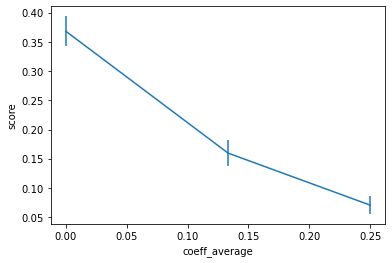

In [140]:
method = 'ind'

score_mean, std_error = std_error_ind(configs_score, reps_update, boot_samples = 200)

x = coeff_avg_list(min_coeff,max_coeff,step_size, neg=True)
y = score_mean 
if method == 'ind':
    y = 1-y
    
plt.errorbar(x,y,  yerr = std_error)#, label = 'c_{ind}')
plt.ylabel('score')
plt.xlabel('coeff_average')

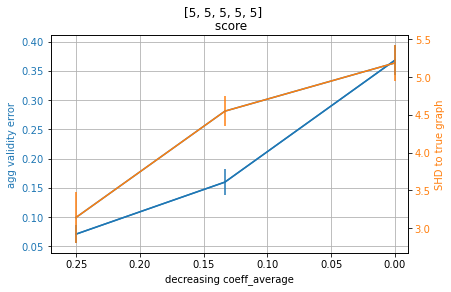

In [141]:
# x = 0.25,0.18,0.12,0.05,0.0
# y = ind_score_mean

fig, (ax1) = plt.subplots(1, 1, figsize=(6.4,  4))#, layout="constrained")
fig.suptitle(N_array)
color1 = 'tab:blue'
color2 = 'tab:orange'

ax1.plot(x, y, color = color1)
ax1.errorbar(x, y, yerr=std_error)
ax1.set_xlim(0.27, -0.01)   # inverted fixed limits
ax1.set_title(' score')
ax1.set_xlabel('decreasing coeff_average')
ax1.set_ylabel('agg validity error', color = color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

shd_mean, shd_std_error = std_error_ind(configs_shd, reps_update, boot_samples = 200)

y2 = shd_mean
y2err = shd_std_error

ax_shd = ax1.twinx()
ax_shd.plot(x, y2)
ax_shd.set_ylabel('SHD to true graph', color=color2)  # we already handled the x-label with ax1
ax_shd.errorbar(x, y2, yerr=y2err)
ax_shd.tick_params(axis='y', labelcolor=color2)


In [70]:
score_mean

array([0.8714    , 0.60493333, 0.3384    ])

In [76]:
shd_mean

array([1.33613636, 2.10625   , 1.89795455])

## Compute Script

In [73]:
N_list = [[5]*5, [10]*5] #, [20]*5, [50]*3]
config_list = [(N_list[i][0]) for i in range(len(N_list))]

def save_results(config_list):

    for n_ind,conf in enumerate(config_list):

        print(N_list[n_ind], conf)
        N_array = N_list[n_ind]

        configs_ind_score, configs_den = rep_ind_score(reps, N_array, T)
        configs_score = configs_ind_score/configs_den
        ind_score_mean, std_error = std_error_ind(configs_score, reps)

        all_configs_ind[conf]['results'] = configs_score
        #metrics_dict[conf] = ind_score_mean, std_error
        metrics = ind_score_mean, std_error

        # if os.path.expanduser('~') == '/home/b/b381872':
        #     file_name = os.path.expanduser('~') +'/work/bd1083/Interim_results/agg_validity/%s' %(conf)

        if os.path.expanduser('~') == '/Users/urmininad':
            file_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/new_interim_results/%s' %(conf)

            print("dump ", file_name.replace("'", "").replace('"', '') + '.dat')
            file = open(file_name.replace("'", "").replace('"', '') + '.dat', 'wb')
            pickle.dump(all_configs_ind[conf], file, protocol=-1)        
            file.close()

            file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
            pickle.dump(metrics, file, protocol=-1)        
            file.close()
    

[5, 5, 5, 5, 5] 5
dump  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/5.dat
[10, 10, 10, 10, 10] 10
dump  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/10.dat
[20, 20, 20, 20, 20] 20
dump  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/20.dat
[50, 50, 50] 50
dump  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/50.dat


## Plot Script

In [151]:
if os.path.expanduser('~') == '/home/b/b381872':
    folder_name = os.path.expanduser('~') +'/work/bd1083/Interim_results/agg_validity/metrics/'
    save_folder = os.path.expanduser('~') + '/work/bd1083/Projects/agg_validity/figures/'
elif os.path.expanduser('~') == '/Users/urmininad':
    # folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/Interim_results/'
    # folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/new_interim_results/'
    # save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'
    
    folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/cluster_results/'

def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    name_string = name_string[:-1]
    #print(name_string% (para_setup))

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    results = get_metrics_from_file(para_setup_str)
    return results    

# para_setup = '10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg'
# results = get_results_from_para(para_setup)



# min_coeff = 0.1
# max_coeff = 0.4
# step_size = 0.1
# neg = True        
#coeff_avg_list(min_coeff,max_coeff,step_size,neg)

def gen_plots_coeff(para_setup_list):
    
    fig, (axs) = plt.subplots(4, 2, figsize=(10,  12))#, layout="constrained")
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.3)
    #fig.suptitle(para_setup)
    axs = axs.ravel()
    
    for j,para_setup in enumerate(para_setup_list):

        para_setup_string = para_setup
        # print(para_setup_string)
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]
        # print('paras',paras)

        group_size = int(paras[0])
        n_vars = int(paras[1])
        N_array = [group_size]*n_vars

        min_coeff = float(paras[2])
        max_coeff = float(paras[3])
        step_size = float(paras[4])
        T = int(paras[5])

        ci_test = str(paras[6])
        method = str(paras[7])
        neg = str(paras[8])
        norm = n_vars * (n_vars+1)/2
        
        # print ('N_array', N_array, '\nmincoeff', min_coeff, 'max_coeff', max_coeff, 
        #        'step_size', step_size, '\nci_test', ci_test, 'method', method)
        
        x = coeff_avg_list(min_coeff,max_coeff,step_size, neg)
        results = get_results_from_para(para_setup)
        
        y = results['score_mean']#['shd_mean']
        std_error = results['score_std_error']#['shd_std_error']
        
        color2 = 'tab:orange'
        
        if method =='ind':
            y=1-y 
            axs[j].set_ylim(0.0, 1.0)
            axs[j].set_ylabel('independence error',color=color2)
            
        elif method == 'comm':
            y = y/norm
            std_error = std_error/norm
            axs[j].set_ylabel('commutativity SHD',color=color2)
            axs[j].set_ylim(0.0, 0.35)
        
        
        axs[j].title.set_text(para_setup)

        axs[j].plot(x, y)
        axs[j].errorbar(x, y, yerr=std_error)
        axs[j].set_xlim(0.27, -0.01)   # inverted fixed limits
        
        #axs[j].set_ylim(0.0, 1.0)
        
        #color2 = 'tab:orange'
        axs[j].set_xlabel('decreasing coeff_average')
        #axs[j].set_ylabel('aggregation validity error',color=color2)
        axs[j].tick_params(axis='y', labelcolor=color2)
        axs[j].grid(True)
        
        ax_shd = axs[j].twinx()
        color = 'tab:blue'

        ax_shd.set_ylabel('SHD to true graph', color=color)  
        ax_shd.plot(x, results['shd_mean']/norm, color=color)
        ax_shd.errorbar(x, results['shd_mean']/norm, yerr=results['shd_std_error']/norm)
        ax_shd.tick_params(axis='y', labelcolor=color)
        
        # ax_shd.set_ylim(0.0, 0.38)
        

    fig.tight_layout()
        

load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/5-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/5-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/20-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/20-5-0.1-0.4-0.1-5000-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_valid

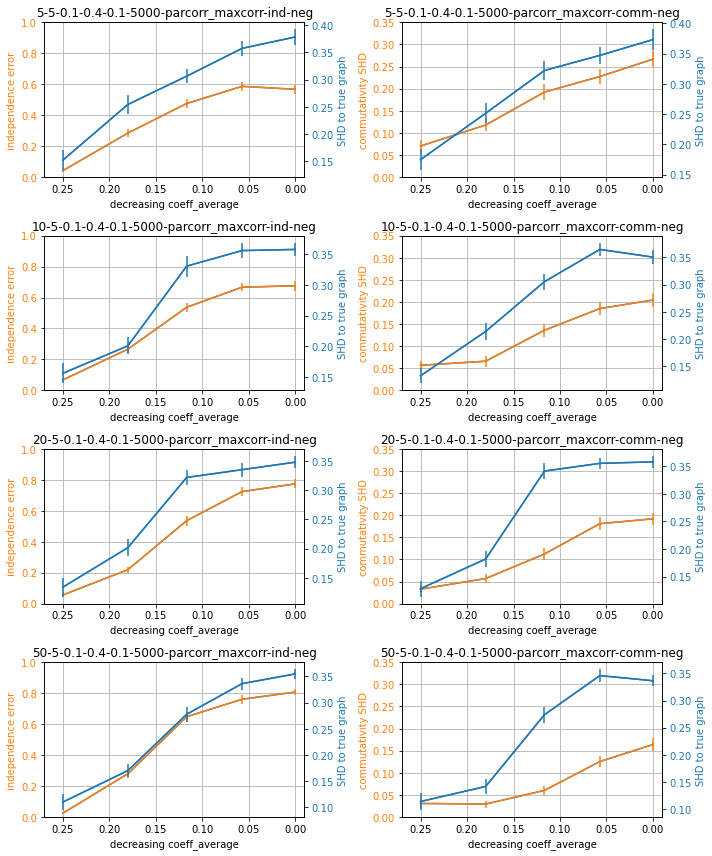

In [148]:
anyconfigurations = [] 
for group_size in [5,10,20,50]:
    for n_vars in [5]:
        for min_coeff in [0.1]:
            for max_coeff in [0.4]:
                for step_size in [0.1]:
                    for T in [5000]:
                        for ci_test in ['parcorr_maxcorr']:
                            for method in ['ind', 'comm']:
                                for coeff_range in ['neg']:
                                    para_setup = (group_size,n_vars,min_coeff,max_coeff,step_size,T,ci_test,method,coeff_range)
                                    name = '%s-'*len(para_setup) % para_setup
                                    name = name[:-1]
                                    anyconfigurations += [name]


gen_plots_coeff(anyconfigurations)

load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/5-5-0.1-0.4-0.1-500-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/5-5-0.1-0.4-0.1-500-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/10-5-0.1-0.4-0.1-500-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/10-5-0.1-0.4-0.1-500-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/20-5-0.1-0.4-0.1-500-parcorr_maxcorr-ind-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/20-5-0.1-0.4-0.1-500-parcorr_maxcorr-comm-neg_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cl

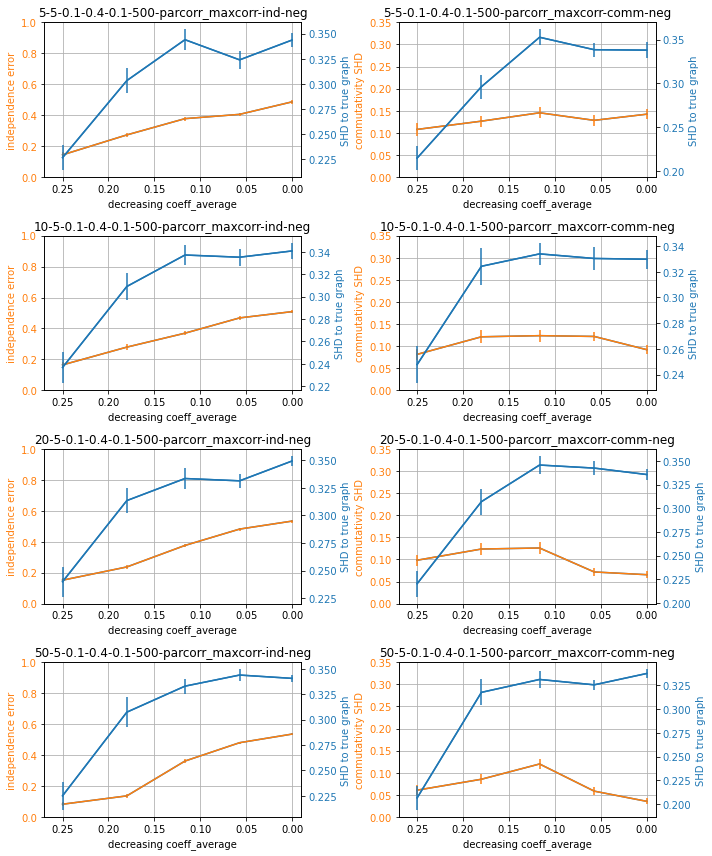

In [152]:
anyconfigurations = [] 
for group_size in [5,10,20,50]:
    for n_vars in [5]:
        for min_coeff in [0.1]:
            for max_coeff in [0.4]:
                for step_size in [0.1]:
                    for T in [500]:
                        for ci_test in ['parcorr_maxcorr']:
                            for method in ['ind', 'comm']:
                                for coeff_range in ['neg']:
                                    para_setup = (group_size,n_vars,min_coeff,max_coeff,step_size,T,ci_test,method,coeff_range)
                                    name = '%s-'*len(para_setup) % para_setup
                                    name = name[:-1]
                                    anyconfigurations += [name]


gen_plots_coeff(anyconfigurations)

ind
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/5-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
comm
ind
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
comm
ind
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/20-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
comm
ind
load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/50-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 
comm


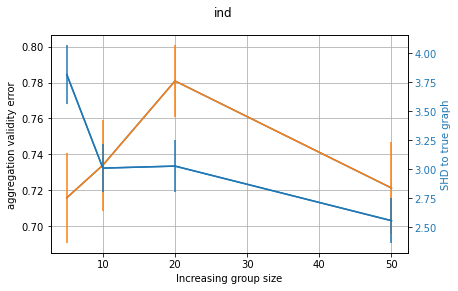

In [638]:
def gen_plots_group(para_setup_list,method_type,coeff_index,sample_size=5000):
    
    # x = np.arange(1,5,1)
    # y = np.zeros((len(X),))
    
    list_x = []
    list_y = []
    list_yerr = []
    list_y2 = []
    list_yerr2 = []
    
    for j,para_setup in enumerate(para_setup_list):
        
        para_setup_string = para_setup
        # print(para_setup_string)
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]
        # print('paras',paras)

        group_size = int(paras[0])
        n_vars = int(paras[1])
        N_array = [group_size]*n_vars

        min_coeff = float(paras[2])
        max_coeff = float(paras[3])
        step_size = float(paras[4])
        T = int(paras[5])

        ci_test = str(paras[6])
        method = str(paras[7])
        neg = str(paras[8])
        
        print(method)
        
        if method == method_type and T == sample_size:
            
            results = get_results_from_para(para_setup)
            list_x.append(group_size)
            list_y.append(results['score_mean'][coeff_index])
            list_yerr.append(results['score_std_error'][coeff_index])
            
            list_y2.append(results['shd_mean'][coeff_index])
            list_yerr2.append(results['shd_std_error'][coeff_index])
    

    #print(list_x,list_y)

    fig, (ax1) = plt.subplots(1, 1, figsize=(6.4,  4))#, layout="constrained")
    fig.suptitle(method_type)

    ax1.plot(list_x, list_y)
    ax1.errorbar(list_x, list_y, yerr=list_yerr)
    #ax1.set_xlim(0.27, -0.01)   # inverted fixed limits
    #ax1.set_title('Comm score')
    ax1.set_xlabel('Increasing group size')
    ax1.set_ylabel('aggregation validity error')
    ax1.grid(True)
    
    ax_shd = ax1.twinx()
    color = 'tab:blue'
    ax_shd.set_ylabel('SHD to true graph', color=color)  # we already handled the x-label with ax1
    ax_shd.plot(list_x, list_y2, color=color)
    ax_shd.errorbar(list_x, list_y2,list_yerr2)
    ax_shd.tick_params(axis='y', labelcolor=color)
    
gen_plots_group(anyconfigurations,'ind',1)

## Old plotting script

In [586]:
if os.path.expanduser('~') == '/home/b/b381872':
    folder_name = os.path.expanduser('~') +'/work/bd1083/Interim_results/agg_validity/metrics/'
    save_folder = os.path.expanduser('~') + '/work/bd1083/Projects/agg_validity/figures/'
elif os.path.expanduser('~') == '/Users/urmininad':
    folder_name = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/Interim_results/'
    # save_folder = os.path.expanduser('~') + '/Documents/Python/aggregation_validity/figures/'

In [547]:
para_setup = '10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg'   #'10'
para_setup_str = tuple(para_setup.split("-"))
#print(para_setup_str)
results = get_metrics_from_file(para_setup_str)

# save_suffix = '%s-'*len(para_setup_name) % para_setup_name
# save_suffix = save_suffix[:-1]
save_suffix = para_setup#+'-shd'
save_type = 'pdf'
results['score_mean']

load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/Interim_results/10-5-0.1-0.4-0.1-5000-parcorr_maxcorr-ind-neg_metrics.dat 


array([0.93316667, 0.7340175 , 0.46274119, 0.333287  , 0.32373268])

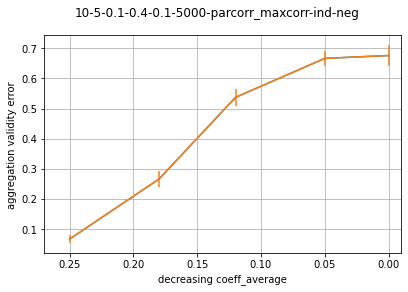

In [463]:
x = 0.25,0.18,0.12,0.05,0.0
y = results['score_mean']#['shd_mean']
std_error = results['score_std_error']#['shd_std_error']

y=1-y #for independence score

fig, (ax1) = plt.subplots(1, 1, figsize=(6.4,  4))#, layout="constrained")
fig.suptitle(save_suffix)

ax1.plot(x, y)
ax1.errorbar(x, y, yerr=std_error)
ax1.set_xlim(0.27, -0.01)   # inverted fixed limits
#ax1.set_title('Comm score')
ax1.set_xlabel('decreasing coeff_average')
ax1.set_ylabel('aggregation validity error')
ax1.grid(True)

#fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type))

# Archive

In [11]:
N = 3
val_min = dict()
graph = np.array([[[''],
        ['-->'],
        ['']],

       [['<--'],
        [''],
        ['<--']],

       [[''],
        ['-->'],
        ['']]], dtype='<U3')

for j in range(N):
    val_min[j] = {(p[0], -p[1]): np.inf
                    for p in zip(*np.where(graph[:, j, :] != ""))}

In [13]:
graph.shape[2]

1

In [8]:
val_min

{0: {(1, 0): inf}, 1: {(0, 0): inf, (2, 0): inf}, 2: {(1, 0): inf}}

In [10]:
tau_min = 0
tau_max = 1
sepsets = dict([(((i, -tau), j), [])
                       for tau in range(tau_min, tau_max + 1)
                       for i in range(N)
                       for j in range(N)])
sepsets

{((0, 0), 0): [],
 ((0, 0), 1): [],
 ((0, 0), 2): [],
 ((1, 0), 0): [],
 ((1, 0), 1): [],
 ((1, 0), 2): [],
 ((2, 0), 0): [],
 ((2, 0), 1): [],
 ((2, 0), 2): [],
 ((0, -1), 0): [],
 ((0, -1), 1): [],
 ((0, -1), 2): [],
 ((1, -1), 0): [],
 ((1, -1), 1): [],
 ((1, -1), 2): [],
 ((2, -1), 0): [],
 ((2, -1), 1): [],
 ((2, -1), 2): []}

In [402]:
variant = 'N'
vary_N = [5,10]#[2, 3, 5, 10, 20]                                      
model = 'random_lineargaussian'
N=10
coeff = 0.5
auto  = 0.3#[0., 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999]:  
contemp_fraction = 0.3
tau_max = 5 #[1, 5, 10, 15, 20, 25]:
T =500#200
ci_test = 'cmi_knn' #'par_corr' # ['oracle']
pc_alpha = 0.01 #, 0.05]: #, 0.1]:

para_setup_name = (variant, N, coeff, auto, contemp_fraction, tau_max, T, ci_test, pc_alpha)
save_suffix = '%s-'*len(para_setup_name) % para_setup_name
save_suffix = save_suffix[:-1]

In [404]:
type(save_suffix)

str

In [434]:
para_setup = '5-5-0.1-0.4-0.1-500-parcorr_maxcorr-ind-neg'   #'10'
para_setup_str = tuple(para_setup.split("-"))
#print(para_setup_str)
results = get_metrics_from_file(para_setup_str)

# save_suffix = '%s-'*len(para_setup_name) % para_setup_name
# save_suffix = save_suffix[:-1]
save_suffix = para_setup#+'-shd'
save_type = 'pdf'
results

load from metrics file  /Users/urmininad/Documents/Python/aggregation_validity/cluster_results/5-5-0.1-0.4-0.1-500-parcorr_maxcorr-ind-neg_metrics.dat 


{'score_mean': array([0.89296667, 0.5801119 , 0.59488988, 0.5970625 , 0.58890774]),
 'score_std_error': array([0.03841989, 0.05371032, 0.03511099, 0.0320101 , 0.04123205]),
 'shd_mean': array([3.4005, 5.5265, 5.629 , 4.177 , 4.807 ]),
 'shd_std_error': array([0.5897031 , 0.56722813, 0.49905811, 0.38022493, 0.47026695])}

In [112]:
para_setup = '10'
name_string = '%s-'#*len(para_setup)  # % para_setup
print(name_string)
name_string = name_string[:-1]
print(name_string)
results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')

%s-
%s


In [352]:
N_list = [[5]*5, [10]*5, [20]*5, [50]*3]
config_list = [(N_list[i][0]) for i in range(len(N_list))]
all_configs_ind = dict([(conf, {'results':{},} ) for conf in config_list])
all_configs_com = dict([(conf, {'results':{},} ) for conf in config_list])

In [357]:
all_configs_ind[5]['results']

{}

In [233]:
metrics_dict = dict([(conf, [] ) for conf in config_list])
metrics_dict

{5: [], 10: [], 20: [], 50: []}

In [ ]:
def ind_score_list(N_array, min_coeff, max_coeff, step_size, T,pc_alpha = pc_alpha):
    
    coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
    print(coupling_coeffs)
    print('average coeff', (np.array(coupling_coeffs)).mean())
    coupling_range = len(coupling_coeffs)
    ind_scores = np.zeros(coupling_range+1)
    dens = np.zeros(coupling_range+1)
    shd_to_true_graph = np.zeros(coupling_range+1)

    for j in range(coupling_range +1):

        links_full, links_vec = gen.generate_random_contemp_vec_model(
        N_array, 
        coupling_coeffs, 
        coupling_funcs, 
        auto_coeffs_array, 
        tau_max, 
        contemp_frac_array,
        contemp_frac,
        L_internal_density = None,
        L_external_density = None,
        random_state=None)

        N = len(links_full.keys())

        # Vector data
        data, nonstat = gen.generate_nonlinear_contemp_timeseries(links_full,
            T, noises=[np.random.randn for i in range(N)])
        true_graph = toys.links_to_graph(links_vec)

        # Aggregated data
        data_agg = aggregate_data(data, partition=N_array)

        # PC-alg on aggregated data
        sepsets,p_matrix,graph,dag = pc_alg(data_agg,pc_alpha)
        
        # Compute independence score
        ind_scores[j],dens[j] = comp_ind_score(data,p_matrix,sepsets)


        if j < coupling_range:
            coupling_coeffs += [-c for c in [coupling_coeffs[j]]]
            print(coupling_coeffs)
            print('average coeff', (np.array(coupling_coeffs)).mean())
            
            
    return ind_scores,dens

def dags_coarse_fine(data, vectorize_fine_vars, partition_std, partition_fine, pc_alpha):
    
    agg_std = aggregate_data(data,partition_std)
    agg_fine = aggregate_data(data, partition_fine)

    
    #tot_vars = len(partition_std)
    
    sepsets_std, p_matrix_std, graph_std, dag_std = pc_alg(agg_std,pc_alpha)
    
    sepsets_fine, p_matrix_fine, graph_fine, dag_fine = pc_alg(agg_fine, pc_alpha,vector_vars = vectorize_fine_vars)
    
    return dag_std, dag_fine

In [195]:
def ind_score_config(N_array, min_coeff, max_coeff, step_size, T,pc_alpha = pc_alpha):
    
    coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))
    print('coupling_coeffs',coupling_coeffs)
    print('average coeff', (np.array(coupling_coeffs)).mean())

    links_full, links_vec = gen.generate_random_contemp_vec_model(
    N_array, 
    coupling_coeffs, 
    coupling_funcs, 
    auto_coeffs_array, 
    tau_max, 
    contemp_frac_array,
    contemp_frac,
    L_internal_density = None,
    L_external_density = None,
    random_state=None)

    N = len(links_full.keys())

    # Vector data
    data, nonstat = gen.generate_nonlinear_contemp_timeseries(links_full,
        T, noises=[np.random.randn for i in range(N)])
    true_graph = toys.links_to_graph(links_vec)

    # Aggregated data
    data_agg = aggregate_data(data, partition=N_array)
    sepsets,p_matrix,graph,dag = pc_alg(data_agg)

    # Compute independence score
    ind_scores,dens = comp_ind_score(data,p_matrix,sepsets)
            
            
    return ind_scores,dens

In [229]:
#min_coeff = 0.2
max_coeff = 0.5
step_size = 0.1
N_array = [50]*3
T=1000

# for min_coeff in [0.2,-0.2,-0.3,-0.4,-0.5]:
#     ind_scores,dens = ind_score_config(N_array, min_coeff, max_coeff, step_size, T) #ind_score_list(N_array, min_coeff, max_coeff, step_size, T,pc_alpha = pc_alpha)
#     print('score,den',ind_scores,dens)
    

min_coeff = 0.2
print('-------------------')    
print('list',ind_score_list(N_array, min_coeff, max_coeff, step_size, T,pc_alpha = pc_alpha))

-------------------
[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001]
average coeff 0.3500000000000001
[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, -0.2]
average coeff 0.24000000000000007
[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, -0.2, -0.30000000000000004]
average coeff 0.15000000000000005
[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, -0.2, -0.30000000000000004, -0.4000000000000001]
average coeff 0.07142857142857147
[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, -0.2, -0.30000000000000004, -0.4000000000000001, -0.5000000000000001]
average coeff 0.0
list (array([1., 1., 1., 0., 1.]), array([1., 1., 1., 2., 2.]))


In [ ]:
list (array([1., 1., 0., 0., 1.]), array([1., 1., 1., 2., 2.]))

In [218]:
min_coeff = -0.2
max_coeff = 0.5
#list(np.arange(min_coeff, max_coeff+0.1, step_size))
#len(np.array(list(np.arange(-max_coeff, -min_coeff+0.1, step_size))+list(np.arange(min_coeff, max_coeff+0.1, step_size))))
if min_coeff>0:
    print(list(np.arange(min_coeff, max_coeff+0.1, step_size)))
elif min_coeff<0:
    min_coeff = abs(min_coeff)
    print(list(np.arange(min_coeff, max_coeff+0.1, step_size))+list(np.arange(-min_coeff, -min_coeff+0.1, step_size)))

[0.2, 0.30000000000000004, 0.4000000000000001, 0.5000000000000001, -0.2]


In [227]:
min_coeff = 0.2
max_coeff = 0.5
coupling_coeffs = list(np.arange(min_coeff, max_coeff+0.1, step_size))

j=3
coupling_coeffs += [-c for c in coupling_coeffs[:j]]
coupling_coeffs

[0.2,
 0.30000000000000004,
 0.4000000000000001,
 0.5000000000000001,
 -0.2,
 -0.30000000000000004,
 -0.4000000000000001]

In [34]:
reps = 10

In [35]:
configs_ind_score, configs_den = rep_ind_score(reps, N_array, 10000)

rep 0
rep 1
rep 2
rep 3
rep 4
rep 5
rep 6
rep 7
rep 8
rep 9


In [42]:
configs_score = configs_ind_score/configs_den

In [74]:
configs_score.shape

(10, 5)

Text(0.5, 0, 'coeff_average')

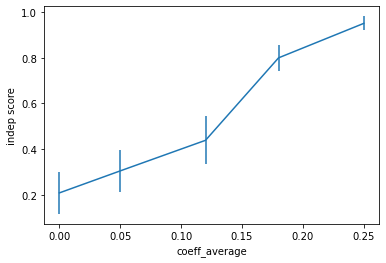

In [77]:
ind_score_mean, std_error = std_error_ind(configs_score, reps)
plt.errorbar([0.25,0.18,0.12,0.05,0.0],ind_score_mean ,  yerr = std_error)
plt.ylabel('indep score')
plt.xlabel('coeff_average')

Text(0.5, 0, 'coeff_average')

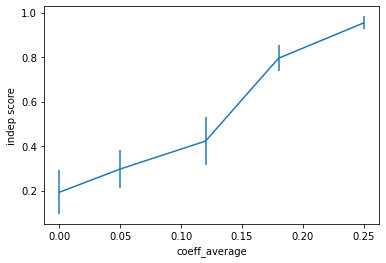

In [80]:
configs_score_loc_20 = configs_score
ind_score_mean, std_error = std_error_ind(configs_score_loc_20, reps)
plt.errorbar([0.25,0.18,0.12,0.05,0.0],ind_score_mean ,  yerr = std_error)
plt.ylabel('indep score')
plt.xlabel('coeff_average')